In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from EngineerFeature import FeatureEngineer
from sklearn.discriminant_analysis import StandardScaler

In [85]:
# Veri setini yükle
data = pd.read_csv('../final_data.csv')

# Özellikler ve hedef değişkeni ayır
X = data.drop("popularity", axis=1)
y = data["popularity"]

# Eğitim ve test setlerine ayır (%80 eğitim, %20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

Eğitim seti boyutu: (22684, 39)
Test seti boyutu: (5672, 39)


In [86]:
# Pipeline ile data leakage önleme
from sklearn.pipeline import Pipeline

pipeline_base = Pipeline([
    ('feature_eng', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=1.0, random_state=42, max_iter=10000))
])

pipeline_base.fit(X_train, y_train)

# Tahminler
y_train_pred = pipeline_base.predict(X_train)
y_test_pred = pipeline_base.predict(X_test)

# Metrikleri hesapla
print(f"Eğitim - MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
print(f"Eğitim - RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
print(f"Eğitim - R²: {r2_score(y_train, y_train_pred):.4f}")
print()
print(f"Test - MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
print(f"Test - RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
print(f"Test - R²: {r2_score(y_test, y_test_pred):.4f}")

Eğitim - MAE: 10.3068
Eğitim - RMSE: 15.2355
Eğitim - R²: 0.5878

Test - MAE: 15.7541
Test - RMSE: 20.4769
Test - R²: 0.2464


In [87]:
# Pipeline ile GridSearchCV - Daha küçük alpha değerleri ve daha fazla CV
pipeline = Pipeline([
    ('feature_eng', FeatureEngineer()),
    ('scaler', StandardScaler()),
    ('lasso', Lasso(random_state=24, max_iter=10000))
])

# Daha küçük alpha değerleri (0.01'den 100'e kadar)
param_grid = {
    "lasso__alpha": np.logspace(-2, 2, 20)
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5, 
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

print("GridSearchCV başlıyor...")
grid_search.fit(X_train, y_train)

GridSearchCV başlıyor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,Pipeline(step...m_state=24))])
,param_grid,{'lasso__alpha': array([1.0000...00000000e+02])}
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [88]:
print("HİPERPARAMETRE OPTİMİZASYONU SONUÇLARI")
print(f"En iyi alpha değeri: {grid_search.best_params_['lasso__alpha']:.8f}")
print(f"En iyi CV R²: {grid_search.best_score_:.8f}")

HİPERPARAMETRE OPTİMİZASYONU SONUÇLARI
En iyi alpha değeri: 0.01000000
En iyi CV R²: 0.21831693


In [89]:
# Lasso sonuçları
best_lasso_pipeline = grid_search.best_estimator_
y_test_pred_lasso = best_lasso_pipeline.predict(X_test)
y_train_pred_lasso = best_lasso_pipeline.predict(X_train)

train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print("\n--- LASSO MODEL ---")
print(f"Eğitim R²: {train_r2_lasso:.4f}")
print(f"Test R²: {test_r2_lasso:.4f}")
print(f"CV R²: {grid_search.best_score_:.4f}")
print(f"Train-Test Fark: {abs(train_r2_lasso - test_r2_lasso):.4f}")

best_lasso = best_lasso_pipeline.named_steps['lasso']
nonzero_lasso = np.sum(best_lasso.coef_ != 0)
print(f"Seçilen feature sayısı: {nonzero_lasso}")



--- LASSO MODEL ---
Eğitim R²: 0.5938
Test R²: 0.2518
CV R²: 0.2183
Train-Test Fark: 0.3420
Seçilen feature sayısı: 18


In [90]:
# GridSearchCV sonuçlarını detaylı analiz
results_df = pd.DataFrame(grid_search.cv_results_)
results_df["alpha"] = results_df["param_lasso__alpha"].astype(float)
results_df["mean_R2"] = results_df["mean_test_score"]
results_df["std_R2"] = results_df["std_test_score"]

results_sorted = results_df.sort_values("rank_test_score")
print("\nTüm alpha değerleri için sonuçlar (en iyi 10):")
print(results_sorted[["alpha", "mean_R2", "std_R2", "rank_test_score"]].head(10).to_string(index=False))



Tüm alpha değerleri için sonuçlar (en iyi 10):
   alpha  mean_R2   std_R2  rank_test_score
0.010000 0.218317 0.014496                1
0.016238 0.218256 0.014469                2
0.026367 0.218147 0.014424                3
0.042813 0.217946 0.014354                4
0.069519 0.217598 0.014276                5
0.112884 0.217172 0.014208                6
0.183298 0.216337 0.014055                7
0.297635 0.215018 0.013743                8
0.483293 0.213268 0.013392                9
0.784760 0.211846 0.013183               10


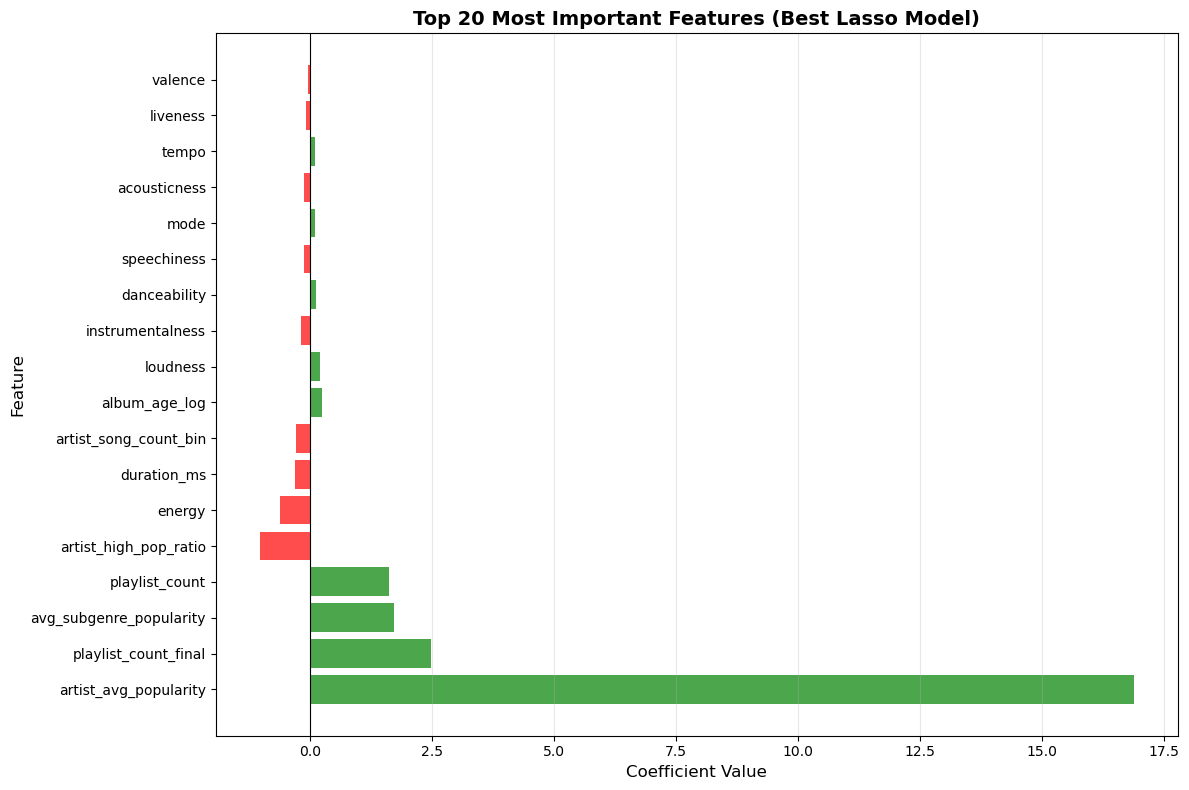

In [91]:
# Görselleştirme 4: En iyi modelin feature importance
# Pipeline'dan transformed feature isimlerini al
fe = best_lasso_pipeline.named_steps['feature_eng']
X_temp = fe.transform(X_train.iloc[:1])  # Sadece feature isimlerini almak için
feature_names = X_temp.columns

best_feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": best_lasso.coef_
})

# Sıfır olmayan katsayıları al ve mutlak değere göre sırala
top_features = best_feature_importance[best_feature_importance["coefficient"] != 0].copy()
top_features = top_features.sort_values(by="coefficient", key=abs, ascending=False).head(20)

plt.figure(figsize=(12, 8))
colors = ["green" if x > 0 else "red" for x in top_features["coefficient"]]
plt.barh(range(len(top_features)), top_features["coefficient"], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features["feature"])
plt.xlabel("Coefficient Value", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 20 Most Important Features (Best Lasso Model)", fontsize=14, fontweight="bold")
plt.axvline(x=0, color="black", linestyle="-", linewidth=0.8)
plt.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()


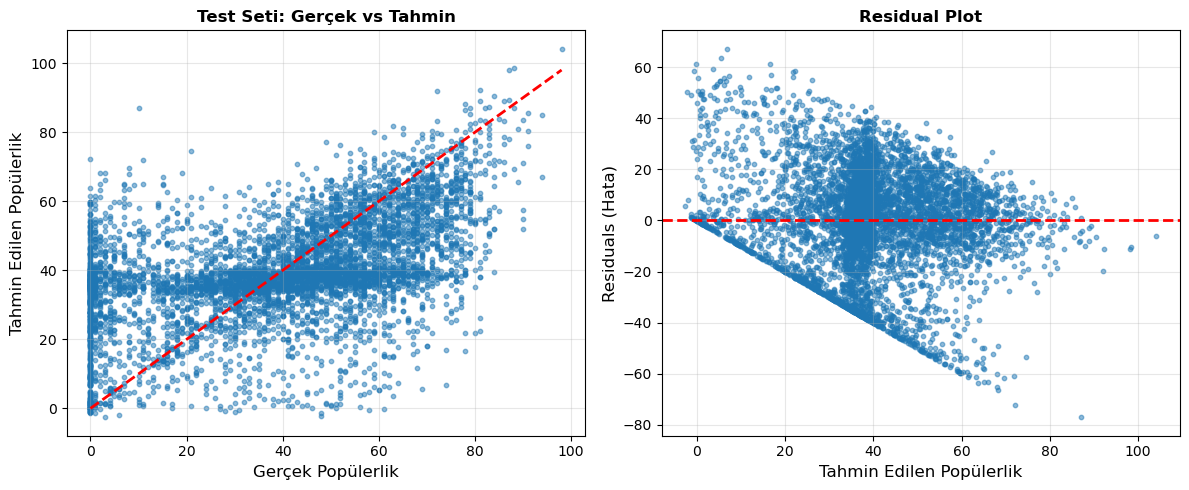

In [92]:
# Görselleştirme 5: Gerçek vs Tahmin edilen değerler
plt.figure(figsize=(12, 5))

# Test seti
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_best, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Gerçek Popülerlik", fontsize=12)
plt.ylabel("Tahmin Edilen Popülerlik", fontsize=12)
plt.title("Test Seti: Gerçek vs Tahmin", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3)

# Residual plot
plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred_best
plt.scatter(y_test_pred_best, residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel("Tahmin Edilen Popülerlik", fontsize=12)
plt.ylabel("Residuals (Hata)", fontsize=12)
plt.title("Residual Plot", fontsize=12, fontweight="bold")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()